# 뉴스 요약본 만들기

## 텍스트 요약

텍스트요약은 추출적 요약과 추상적 요약으로 나눌 수 있다. 

- 추출적 요약

    원문에서 문장을 추출해서 요약하는 방법. TextRank 알고리즘으로 기사를 가장 잘 나타내는 단어로 이루어진 핵심문장을 잘 뽑아낸다.
    
   
- 추상적 요약

    원문의 내용이 요약된 새로운 문장을 생성한다. 자연어 생성이다. 

seq2seq 모델로 추상적 요약방식의 텍스트 요약기를 만든다. seq2seq는 두 개의 RNN 아키텍쳐를 사용해서 입력 시퀀스로부터 출력 시퀀스를 생성하는 모델이다.

원문을 첫 번째 RNN인 인코더로 입력하면 하나의 고정된 벡터로 변환된다. 이 벡터를 컨텍스트 벡터라 한다. 두번째 RNN인 디코더는 컨텍스트 벡터를 받아 한 단어씩 생성해서 요약 문장을 완성한다.

인코더/디코더인 RNN을 LSTM으로 사용한다. LSTM과 바닐라 RNN은 차이가 있다. 인코더가 디코더에 전달하는 컨텍스트 벡터에 hidden state h와 cell state c 두 값이 모두 존재해야 한다.  

디코더는 시작 토큰 SOS가 입력되면 각 시점 마다 단어를 생성하고 종료 토큰 EOS를 예측 할 때까지 반복한다. 전처리로 시퀀스의 앞,뒤에 시작/종료 토큰을 넣어줘야 한다.

어텐션 메커니즘으로 새로운 컨텍스트 벡터 사용

기존 seq2seq는 인코더의 마지막 time step의 hidden state를 컨텍스트 벡터로 사용했다. 이 컨텍스트 정보는 이미 입력 시퀀스의 많은 정보가 손실되었다. 어텐션 메커니즘은 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영된다. 인코더에 모든 hidden state가 동일한 비중으로 반영되지는 않고 디코더의 현재 time step의 예측에 인코더의 각 step이 영향을 미치는 가중합으로 계산된다. 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 디코더의 현재 스텝에 따라 계속 달라진다. 문장 생성 부위마다 유연하게 바뀌기 때문에 정확한 예측이 가능하다.

1. seq2seq를 사용합니다.

2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.

3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.

4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.

5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.

6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

## 1. 데이터 준비

케글의 아마존 리뷰 데이터셋을 사용

NLTK의 불용어를 사용한다. 불용어는 문자에 자주 등장하지만 의미를 분석,요약하는데는 거의 의미가 없는 단어들이다. 

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


시간상 샘플은 10만개만 사용한다.

In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# 열 2개만 남긴다.
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
58435,We have been trying to get my son to eat fruit...,Perfect for that picky toddler who loves a lit...
13337,My dogs love them. They swallow them before re...,doggy pill eats
34869,"I'm not usually a green tea fan, but I adore l...",Most Excellent Tea!
6108,I purchased this product for my goats initiall...,Excellent quality
97669,I've been drinking 2 cups a day for several mo...,I like the taste!
48710,My wife and I decided to have a candy bar/tabl...,These were the hit at the wedding!
28342,Let me start by saying that I love Skittles an...,Not Into Sour Candies...
38789,From the RiceSelect website (that produces tex...,Not GMO
46821,"Dark chocolate lovers will confirm, at the fir...",Serious chocolate
92643,I have to write a review in order to get this ...,"No Rating, No Comment"


Text 시퀀스를 입력 받으면 Summary를 출력하는 모델을 만든다.

## 2. 데이터 전처리

총 10만개의 샘플 중 중복되지 않은 샘플을 확인한다.

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


Text는 달라도 summary는 동일할 수 있다. Text가 같다면 중복데이터이니 제거한다.

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


drop_duplicates()가 중복된 Null값을 지워주긴 하지만 Null이 하나 남아있을 수 있다. Null을 확인한다.

In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


하나 남은 Null값을 지워준다.

In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


### 텍스트 정규화와 불용어 제거

- 텍스트 정규화

    it'll은 it will과 같고 mustn't는 must not과 같다. 두 단어가 같은 뜻이라는 것을 알려줘서 연산량을 줄인다. 사전을 만든다.
    
   

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# 불용어 사전 준비
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터 전처리 함수를 만들어서 사용한다. 샘플의 Text는 불용어를 제거하고 Summary는 불용어 제거를 하지 않는다. 불용어를 남기는 편이 자연스러운 문장이 되기 때문이다.

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


전처리 전,후 결과 확인을 위해 임의의 샘플을 만들어서 테스트해본다.

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


함수의 작동을 확인했으니 실제 데이터를 전처리한다. 불용어 처리때문에 Text와 Summary를 따로 전처리해야 한다. 

In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


불용어 제거를 안하기 위해서 False를 넣었다.

In [14]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


전처리가 끝난 후 다시 한 번 빈 샘플이 생겼는지 확인해본다. 빈 값을 Null로 대체한다.

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 88355


최종적으로 데이터 전처리가 끝났다.

## 3. 훈련/테스트 셋 나누기

### 샘플 최대 길이 정하기

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


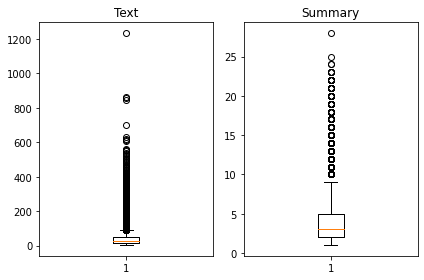

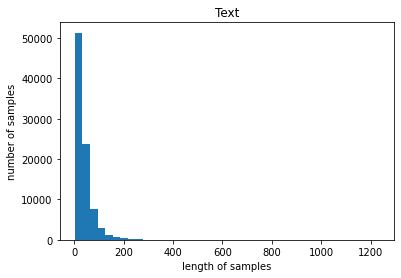

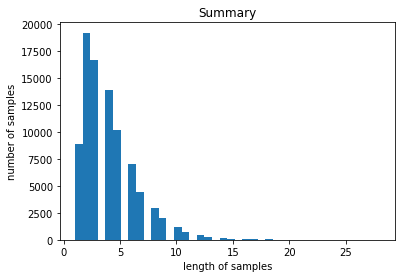

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

# 각 문장을 단어로 잘라서 갯수를 센다.
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

각 컬럼의 길이 분포를 확인하고 최대길이를 정한다.

In [19]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


지정한 최대길이안에 얼마나 많은 샘플이 들어있는지 함수를 만들어 확인한다.

In [20]:
def below_threshold_len(max_len, nested_list):
    cnt=0
    for s in nested_list:
        if((len(s.split()) <= max_len)):
            cnt += 1
    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"%(max_len, cnt / len(nested_list)))

In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


최대 길이로 패딩을 하면 해당 길이보다 긴 샘플은 내용이 잘린다. 그래서 내용을 자르는 게 아니라 정해진 길이보다 길면 샘플을 제외시키는 방식으로 데이터를 정제한다.

In [22]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print("전체 샘플수 :", (len(data)))

전체 샘플수 : 65818


### 시작 토큰과 종료 토큰 추가하기

요약데이터에 시작토큰/종료토큰을 붙인 열을 각각 생성한다. 

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x: 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x: x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


이렇게 만든 데이터를 넘파이 배열로 만든다.

In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련/테스트 셋 분리

패키지를 사용하지 않고 직접 분리해본다.

우선 encoder_input과 크기와 형태가 같고 순서가 섞인 정수 시퀀스를 생성한다.

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[62650 63946 37847 ... 56792 31683 25135]


이 정수 시퀀스를 이용해서 샘플 순서를 정의하면 샘플이 잘 섞이게 된다.

In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print("잘 섞었다!")

잘 섞었다!


이제 섞인 데이터를 8:2 비율로 훈련/테스트 셋을 분리한다. 전체 크기에서 0.2를 곱해서 테스트 데이터 크기를 정한다.

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print("테스트 셋의 수 :", n_of_val)

테스트 셋의 수 : 13163


전체 데이터를 분할한다.

In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [29]:
a = [1,2,3,4,5,6,7,8,9]
b = a[:-5]
c = a[-5:]
b,c

([1, 2, 3, 4], [5, 6, 7, 8, 9])

## 4. 정수 인코딩

컴퓨터가 텍스트를 숫자로 처리할 수 있도록 훈련/테스트 데이터의 단어를 모두 정수로 바꿔야 한다. 각 단어에 고유한 정수를 맵핑한다. 이 과정이 단어집합 만들기다. 

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [31]:
src_tokenizer.word_index

{'like': 1,
 'good': 2,
 'great': 3,
 'taste': 4,
 'product': 5,
 'love': 6,
 'one': 7,
 'coffee': 8,
 'flavor': 9,
 'would': 10,
 'tea': 11,
 'really': 12,
 'get': 13,
 'amazon': 14,
 'best': 15,
 'price': 16,
 'buy': 17,
 'much': 18,
 'food': 19,
 'time': 20,
 'little': 21,
 'find': 22,
 'use': 23,
 'tried': 24,
 'better': 25,
 'well': 26,
 'also': 27,
 'chocolate': 28,
 'make': 29,
 'try': 30,
 'dog': 31,
 'eat': 32,
 'even': 33,
 'bought': 34,
 'delicious': 35,
 'found': 36,
 'order': 37,
 'could': 38,
 'sweet': 39,
 'cup': 40,
 'tastes': 41,
 'drink': 42,
 'recommend': 43,
 'used': 44,
 'bag': 45,
 'loves': 46,
 'cannot': 47,
 'favorite': 48,
 'sugar': 49,
 'first': 50,
 'store': 51,
 'nice': 52,
 'free': 53,
 'way': 54,
 'made': 55,
 'box': 56,
 'go': 57,
 'got': 58,
 'perfect': 59,
 'dogs': 60,
 'easy': 61,
 'think': 62,
 'since': 63,
 'ordered': 64,
 'day': 65,
 'give': 66,
 'water': 67,
 'mix': 68,
 'bit': 69,
 'snack': 70,
 'ever': 71,
 'hot': 72,
 'flavors': 73,
 'many': 74,

이렇게 만든 단어 집합에서 빈도수가 낮은 단어는 훈련데이터에서 제외한다. `src_tokenizer.word_counts.items()`를 사용하면 각 단어의 빈도수를 확인할 수 있다.

In [32]:
# src_tokenizer.word_counts.items()
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 당어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq += value
    
    # 단어의 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32040
등장 빈도가 6번 이하인 희귀 단어의 수: 23773
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8267
단어 집합에서 희귀 단어의 비율: 74.19787765293383
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3948294753280774


encoder_input_train에는 약 3만개의 단어가 있다. 빈도가 7회 미만인 단어는 전체 단어의 74%이다. 하지만 실제로 전체 데이터의 등장 빈도수에서 희귀단어가 차지하는 비율은 3.39% 밖에 안된다. 즉, 26%의 단어만 96% 사용된다는 뜻이다. 자주 쓰는 단어만 대부분 사용된다.

빈도수 7회 미만 단어는 정수 데이터에서 제거한다. 단어 집합의 크기를 8000으로 제한한다.

In [33]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

print("단어 집합 생성완료!")

단어 집합 생성완료!


`texts_to_sequences()`는 생성된 단어 집합을 기반으로 입력 텍스트 데이터의 단어를 정수로 변환한다. 희귀 단어는 사라지게 된다.

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 변환됐는지 샘플 출력
print(encoder_input_train[:3])

[[22, 3255, 751, 293, 748, 355, 3538, 6806, 146, 25, 1742, 113, 2426, 4928, 876], [9, 306, 48, 99, 22, 134, 200, 441, 27, 9, 40, 362, 66, 4086, 354, 2612, 155, 16, 17, 1102], [80, 4622, 10, 66, 3997, 319, 38, 33, 4, 1, 397, 200, 122, 714, 2307, 13, 812, 106, 776, 1110, 1303, 4766, 714, 572, 17, 480, 1522, 215, 26, 147, 20, 29, 4, 1072, 292]]


Summary 데이터도 정수 인코딩 해준다.

In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

print("단어 집합 생성완료!")

단어 집합 생성완료!


역시 위와 같이 빈도수를 계산한다.

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10557
등장 빈도가 5번 이하인 희귀 단어의 수: 8159
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2398
단어 집합에서 희귀 단어의 비율: 77.28521360234916
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.884886941762838


희귀단어를 제외하고 2000단어로 단어집합을 다시 만들고 정수인코딩을 한다.

In [37]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 593, 677], [1, 94, 30], [1, 889, 570, 91, 15], [1, 251, 571, 867, 19, 5, 8], [1, 16]]
target
decoder  [[593, 677, 2], [94, 30, 2], [889, 570, 91, 15, 2], [251, 571, 867, 19, 5, 8, 2], [16, 2]]


정수 인코딩이 끝났다. 넘어가기 전에 한 가지 확인할 것이 있다. 빈도수가 낮은 단어가 삭제됐기 때문에 빈도수가 낮은 단어들로 구성됐던 샘플의 데이터가 비었을 수 있다. 요약컬럼은 문장의 길이가 짧기 때문에 데이터가 비었을 수 있다. decoder_input과 decoder_target 앞/뒤로 토큰을 붙였기 때문에 최소 길이는 1이다. 훈련/테스트 데이터의 요약문 길이가 1인 샘플의 인덱스를 변수에 저장해서 삭제한다. 

In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1279
삭제할 테스트 데이터의 개수 : 319
훈련 데이터의 개수 : 51376
훈련 레이블의 개수 : 51376
테스트 데이터의 개수 : 12844
테스트 레이블의 개수 : 12844


### 패딩하기

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 5. 모델 설계하기

### 인코더 설계

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 128이고 hidden state의 크기는 256이다. hidden state는 LSTM에서 **수용력**을 결정하는 파라미터다.용량이나 뉴런의 개수라고 생각하면 된다.

인코더 LSTM은 3개 층으로 복잡도를 높였다.

LSTM은 dropout과 recurrent dropout까지 사용한다. recurrent dropout은 dropout을 레이어가 아닌 time step마다 해준다. 즉 time step의 입력을 랜덤하게 생략한다.

### 디코더 설계

LSTM 입력을 정의할 때 initial_state에 hidden state와 cell state를 넣어야 한다.

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다. 그래서 Dense의 인자로 tar_vocab을 주고 활성화 함수로 소프트 맥스 함수를 사용한다.

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

지금까지는 가장 기본적인 seq2seq 모델을 설계했다. 디코더의 출력층을 조금 손봐서 어텐션 메커니즘을 사용한다.

In [43]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 6. 모델 훈련

### 조기종료

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 142s 665ms/step - loss: 2.6988 - val_loss: 2.4107
Epoch 2/50
201/201 [==============================] - 132s 658ms/step - loss: 2.3639 - val_loss: 2.2814
Epoch 3/50
201/201 [==============================] - 132s 658ms/step - loss: 2.2299 - val_loss: 2.1543
Epoch 4/50
201/201 [==============================] - 132s 656ms/step - loss: 2.1139 - val_loss: 2.0773
Epoch 5/50
201/201 [==============================] - 132s 657ms/step - loss: 2.0328 - val_loss: 2.0271
Epoch 6/50
201/201 [==============================] - 133s 660ms/step - loss: 1.9704 - val_loss: 1.9795
Epoch 7/50
201/201 [==============================] - 133s 661ms/step - loss: 1.9171 - val_loss: 1.9500
Epoch 8/50
201/201 [==============================] - 132s 658ms/step - loss: 1.8709 - val_loss: 1.9265
Epoch 9/50
201/201 [==============================] - 132s 657ms/step - loss: 1.8286 - val_loss: 1.9030
Epoch 10/50
201/201 [==============================] - 132s 659m

EarlyStopping을 설정해둬서 훈련을 끝냈다. 검증 데이터의 손실이 2회 이상 증가하면 학습이 멈추게 설정했다. 에퐄을 높게 해둬도 자동으로 오버피팅을 막을 수 있다.

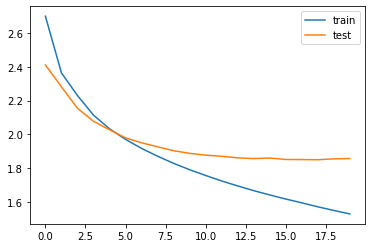

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 7. 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하는 텍스트 데이터를 실제 데이터로 복원해야 하기에 3개의 사전을 준비해둔다.

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때 (인퍼런스 단계)의 방식이 달라서 그에 맞게 모델 설계를 따로 해야한다. 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한 번에 넣고 디코더의 출력과 한 번에 비교할 수 있어서 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

하지만 정답이 없는 인퍼런스 단계에서는 만들어야할 문장의 길이 만큼 디코더가 반복 구조로 동작해야 하기 때문에 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=[decoder_state_input_h, 
                                                                   decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계한다.

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만든다.

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## 8. 모델 테스트

정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만든다. 함수를 만들 때 Text의 정수 시퀀스에서는 패딩을 위해 사용된 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외한다.

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [51]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : used come four tightly wrapped tubes cookies got broken broken many crumbs bad 
실제 요약 : broken cookies and crumbs 
예측 요약 :  broken cookies


원문 : probably best chips ever blows away fact good ingredients hands 
실제 요약 : quality 
예측 요약 :  best chips ever


원문 : tried flavor vanilla vodka good cannot wait try flavors bought best low calorie drink ever 
실제 요약 : delicious 
예측 요약 :  best flavor


원문 : one best products cups system hot chocolate right sweet rich creamy full bodied like sodium flavor like many instant hot chocolates add drops milk awesome 
실제 요약 : great treat 
예측 요약 :  the best


원문 : one favorite drinks half half combination club soda fruit juice fruit juices bit sweet addition carbonation makes whole thing drink amazingly add sugar many shelf beverages even claiming healthful way much sugar guys give none tasty refreshing product would actually buy 
실제 요약 : they got it right 
예측 요약 :  great product


원문 : disapointed particular item also good entertain several times yea

예측 요약 :  my dog loves this toy


원문 : others like lot think taste good texture soft tender kind crumbly prefer honey pepper spicy either nice ok others office buy stick kinds 
실제 요약 : it is ok 
예측 요약 :  good but not great


원문 : tried liked tasty bite basmati rice happy try gogo rice steamed brown rice bowl easy preparation healthy white rite delicious flavor hooked 
실제 요약 : fast easy delicious 
예측 요약 :  great rice


원문 : love buffalo wings heat flavor product offering tongue burning sinus clearing heat good bite flavor describe addictive whole ounce package time sure seems hint bleu cheese taste well adds whole hot wing experience snack opinion kids like well hide bag sometimes ensure get fair share 
실제 요약 : cannot stop eating these puppies 
예측 요약 :  great flavor


원문 : cons pieces small lot sugar around metal get sugar pros ginger quality good nice hot like farms brand best bigger cubes made raw sugar edit stars opening packages realized half pieces bag size great snacking maybe baki

## 9. 추출적 요약 해보기

Summa 패키지에는 추출적 요약을 위한 모듈인 summarize가 있다. 매트릭스 시놉시스를 요약해본다.

### 데이터 다운로드

In [52]:
import requests
from summa.summarizer import summarize

In [53]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [54]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기

Summa의 summarize는 문장 토큰화를 별도로 하지 않아도 내부적으로 토큰화한다. 비율을 설정해 원문의 0.005%만 출력하게 했다.

In [55]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


`split=True`로 리스트로 반환할 수 있다.

In [56]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어 수로 요약문의 크기를 조절할 수 있다.

In [57]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
